In [4]:
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader
import numpy as np

Transformations

In [5]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


Charger tous les splits

In [6]:
train_set = datasets.Flowers102(root='./data', split='train', download=True, transform=transform)
val_set   = datasets.Flowers102(root='./data', split='val', download=True, transform=transform)
test_set  = datasets.Flowers102(root='./data', split='test', download=True, transform=transform)


100%|██████████| 345M/345M [00:27<00:00, 12.6MB/s]
100%|██████████| 502/502 [00:00<00:00, 2.24MB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 31.7MB/s]


Fusionner tous les indices

In [7]:
full_dataset = torch.utils.data.ConcatDataset([train_set, val_set, test_set])

Obtenir les labels de toutes les images

In [8]:
all_labels = np.concatenate([
    np.array(train_set._labels),
    np.array(val_set._labels),
    np.array(test_set._labels)
])


Split stratifié : 90% train, 10% test


In [9]:
train_idx, test_idx = train_test_split(
    np.arange(len(all_labels)),
    test_size=0.2,
    stratify=all_labels,
    random_state=42
)

In [10]:
train_data = Subset(full_dataset, train_idx)
test_data = Subset(full_dataset, test_idx)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=32, shuffle=False)

print(f" Nouveau split : Train = {len(train_data)}, Test = {len(test_data)}")

 Nouveau split : Train = 6551, Test = 1638


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [21]:


class FlowerCNN(nn.Module):
    def __init__(self):
        super(FlowerCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Après 3 pools : 224 -> 112 -> 56 -> 28
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 102)  # 102 classes (Flowers102)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [23]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FlowerCNN().to(device)

Définir la fonction de perte et l’optimiseur

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Boucle d’entraînement

In [26]:
epochs = 5
for epoch in range(epochs):
    running_loss = 0.0
    model.train()

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")




Epoch [1/5], Loss: 4.0803
Epoch [2/5], Loss: 3.1957
Epoch [3/5], Loss: 2.7612
Epoch [4/5], Loss: 2.5086
Epoch [5/5], Loss: 2.2661


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       0.40      0.33      0.36         6
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         6
           4       0.40      0.33      0.36         6
           5       0.22      0.50      0.31         4
           6       1.00      0.25      0.40         4
           7       0.47      0.78      0.58         9
           8       0.33      0.20      0.25         5
           9       0.38      0.75      0.50         4
          10       0.00      0.00      0.00         9
          11       0.15      0.44      0.22         9
          12       0.60      0.60      0.60         5
          13       0.00      0.00      0.00         5
          14       0.50      0.20      0.29         5
          15       0.50      0.25      0.33         4
          16       0.64      0.78      0.70         9
          17       0.00    

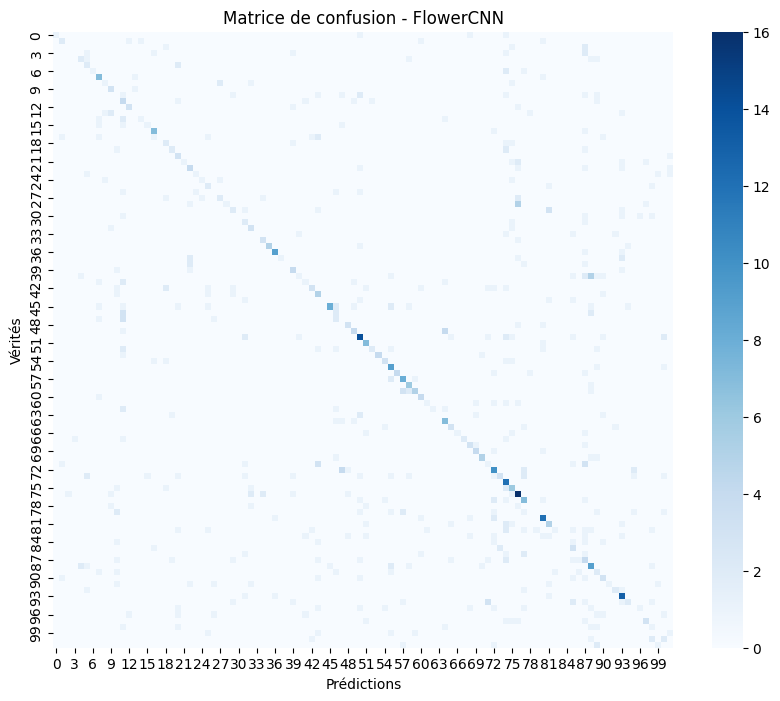

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# 🔹 Rapport global
print(classification_report(y_true, y_pred))

# 🔹 Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap='Blues', annot=False)
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.title("Matrice de confusion - FlowerCNN")
plt.show()


Bloc résiduel

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = F.relu(out)
        return out






Mini-ResNet

In [29]:
class MiniResNet(nn.Module):
    def __init__(self, num_classes=102):
        super(MiniResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 2)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = [ResidualBlock(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MiniResNet(num_classes=102).to(device)

In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [38]:
epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

Epoch [1/20], Loss: 3.7587
Epoch [2/20], Loss: 3.0855
Epoch [3/20], Loss: 2.7408
Epoch [4/20], Loss: 2.4527
Epoch [5/20], Loss: 2.1995
Epoch [6/20], Loss: 1.9937
Epoch [7/20], Loss: 1.8251
Epoch [8/20], Loss: 1.6588
Epoch [9/20], Loss: 1.5389
Epoch [10/20], Loss: 1.4047
Epoch [11/20], Loss: 1.2952
Epoch [12/20], Loss: 1.1847
Epoch [13/20], Loss: 1.0717
Epoch [14/20], Loss: 0.9921
Epoch [15/20], Loss: 0.8909
Epoch [16/20], Loss: 0.7990
Epoch [17/20], Loss: 0.7505
Epoch [18/20], Loss: 0.6582
Epoch [19/20], Loss: 0.6286
Epoch [20/20], Loss: 0.5648


21min d'entrainement

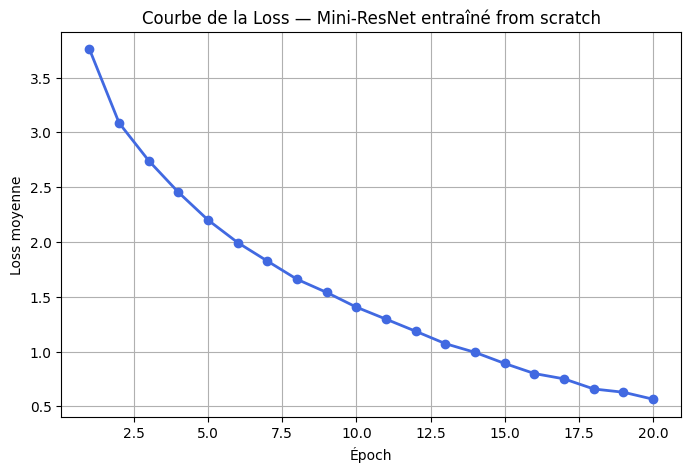

In [27]:
import matplotlib.pyplot as plt

losses_resnet_scratch = [
    3.7587, 3.0855, 2.7408, 2.4527, 2.1995,
    1.9937, 1.8251, 1.6588, 1.5389, 1.4047,
    1.2952, 1.1847, 1.0717, 0.9921, 0.8909,
    0.7990, 0.7505, 0.6582, 0.6286, 0.5648
]

plt.figure(figsize=(8,5))
plt.plot(range(1, len(losses_resnet_scratch)+1), losses_resnet_scratch,
         marker='o', color='royalblue', linewidth=2)
plt.title("Courbe de la Loss — Mini-ResNet entraîné from scratch")
plt.xlabel("Époch")
plt.ylabel("Loss moyenne")
plt.grid(True)
plt.show()


In [43]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

In [44]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# 🔹 Rapport global
print(classification_report(y_true, y_pred))



              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.67      0.67      0.67         6
           2       0.00      0.00      0.00         4
           3       0.38      0.50      0.43         6
           4       0.57      0.67      0.62         6
           5       0.80      1.00      0.89         4
           6       1.00      0.75      0.86         4
           7       0.90      1.00      0.95         9
           8       0.50      0.40      0.44         5
           9       1.00      0.50      0.67         4
          10       0.14      0.11      0.12         9
          11       0.82      1.00      0.90         9
          12       0.80      0.80      0.80         5
          13       1.00      0.80      0.89         5
          14       1.00      0.60      0.75         5
          15       0.25      0.25      0.25         4
          16       1.00      0.78      0.88         9
          17       1.00    

#Charger le modèle pré-entraîné sur ImageNet

In [3]:
import torch
import torch.nn as nn
from torchvision import models

In [11]:

model_ft = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 217MB/s]


In [12]:
num_features = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_features, 102)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)


On réactive SEULEMENT la dernière couche (celle qu’on vient de remplacer)

In [13]:

for param in model_ft.parameters():
    param.requires_grad = False


for param in model_ft.fc.parameters():
    param.requires_grad = True


In [14]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.fc.parameters(), lr=0.001)


In [21]:
epochs = 20
for epoch in range(epochs):
    model_ft.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_ft(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")



Epoch [1/20], Loss: 0.2762
Epoch [2/20], Loss: 0.2478
Epoch [3/20], Loss: 0.2299
Epoch [4/20], Loss: 0.2252
Epoch [5/20], Loss: 0.2119
Epoch [6/20], Loss: 0.2005
Epoch [7/20], Loss: 0.1907
Epoch [8/20], Loss: 0.1803
Epoch [9/20], Loss: 0.1750
Epoch [10/20], Loss: 0.1635
Epoch [11/20], Loss: 0.1686
Epoch [12/20], Loss: 0.1588
Epoch [13/20], Loss: 0.1601
Epoch [14/20], Loss: 0.1455
Epoch [15/20], Loss: 0.1394
Epoch [16/20], Loss: 0.1338
Epoch [17/20], Loss: 0.1414
Epoch [18/20], Loss: 0.1329
Epoch [19/20], Loss: 0.1329
Epoch [20/20], Loss: 0.1320


14min d'entrainement

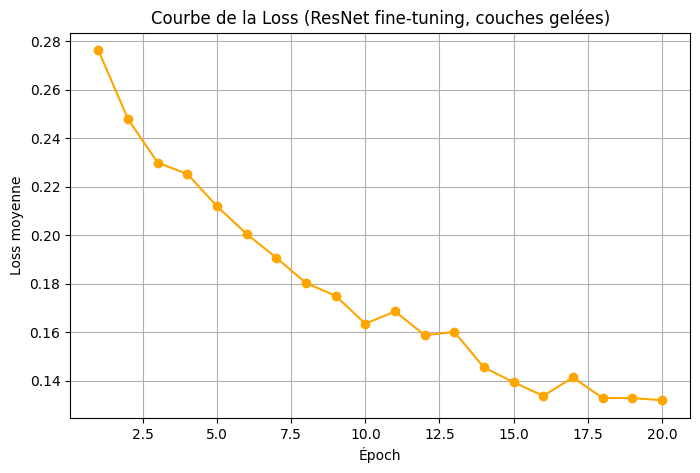

In [26]:
losses = [
    0.2762, 0.2478, 0.2299, 0.2252, 0.2119,
    0.2005, 0.1907, 0.1803, 0.1750, 0.1635,
    0.1686, 0.1588, 0.1601, 0.1455, 0.1394,
    0.1338, 0.1414, 0.1329, 0.1329, 0.1320
]

def plot_loss(losses):
    plt.figure(figsize=(8,5))
    plt.plot(range(1, len(losses)+1), losses, marker='o', color='orange')
    plt.title("Courbe de la Loss (ResNet fine-tuning, couches gelées)")
    plt.xlabel("Époch")
    plt.ylabel("Loss moyenne")
    plt.grid(True)
    plt.show()

plot_loss(losses)

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [22]:
model_ft.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       1.00      1.00      1.00        12
           2       0.50      0.88      0.64         8
           3       0.83      0.45      0.59        11
           4       0.71      0.92      0.80        13
           5       1.00      0.78      0.88         9
           6       0.89      1.00      0.94         8
           7       1.00      1.00      1.00        17
           8       1.00      0.78      0.88         9
           9       1.00      0.89      0.94         9
          10       0.92      0.65      0.76        17
          11       0.81      1.00      0.89        17
          12       1.00      0.90      0.95        10
          13       1.00      1.00      1.00        10
          14       1.00      1.00      1.00        10
          15       1.00      0.62      0.77         8
          16       0.94      1.00      0.97        17
          17       0.78    

In [29]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8980


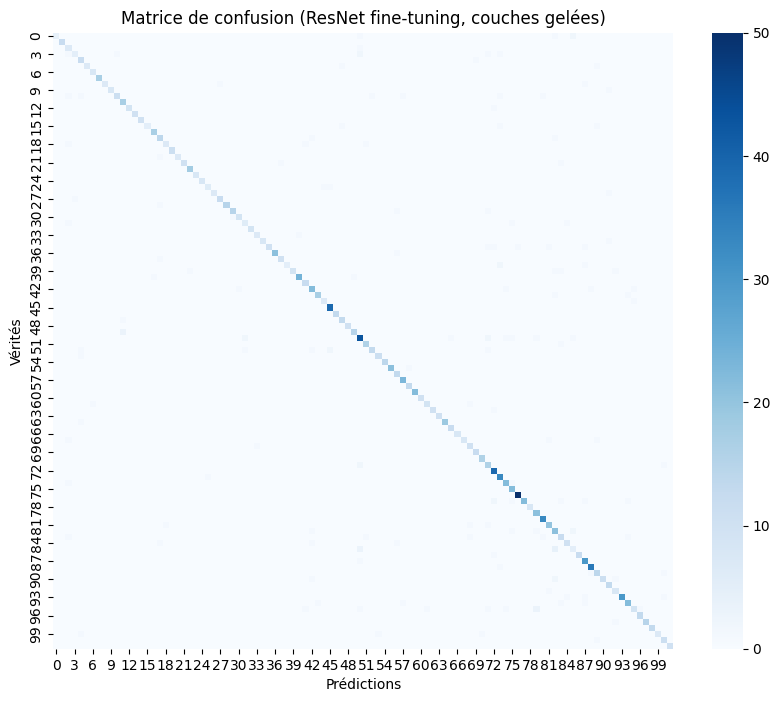

In [31]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap='Blues', annot=False)
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.title("Matrice de confusion (ResNet fine-tuning, couches gelées)")
plt.show()

In [32]:
model_ft = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

In [33]:
num_features = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_features, 102)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

Geler tout le modèle d’abord


In [34]:
for param in model_ft.parameters():
    param.requires_grad = False

Débloquer uniquement les dernières couches

In [35]:
for name, param in model_ft.named_parameters():
    if "layer3" in name or "layer4" in name or "fc" in name:
        param.requires_grad = True


On n’optimise que les couches débloquées, donc :

In [36]:
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model_ft.parameters()),
    lr=0.0003
)
criterion = nn.CrossEntropyLoss()


Pour stabiliser la descente du learning rate :

In [38]:
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)


In [39]:
epochs=20
for epoch in range(epochs):
    model_ft.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_ft(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
    scheduler.step()

Epoch [1/20], Loss: 0.2328
Epoch [2/20], Loss: 0.1198
Epoch [3/20], Loss: 0.0723
Epoch [4/20], Loss: 0.0700
Epoch [5/20], Loss: 0.0673
Epoch [6/20], Loss: 0.0269
Epoch [7/20], Loss: 0.0120
Epoch [8/20], Loss: 0.0061
Epoch [9/20], Loss: 0.0052
Epoch [10/20], Loss: 0.0074
Epoch [11/20], Loss: 0.0042
Epoch [12/20], Loss: 0.0034
Epoch [13/20], Loss: 0.0033
Epoch [14/20], Loss: 0.0024
Epoch [15/20], Loss: 0.0020
Epoch [16/20], Loss: 0.0022
Epoch [17/20], Loss: 0.0017
Epoch [18/20], Loss: 0.0018
Epoch [19/20], Loss: 0.0016
Epoch [20/20], Loss: 0.0013


16min d'entrainement

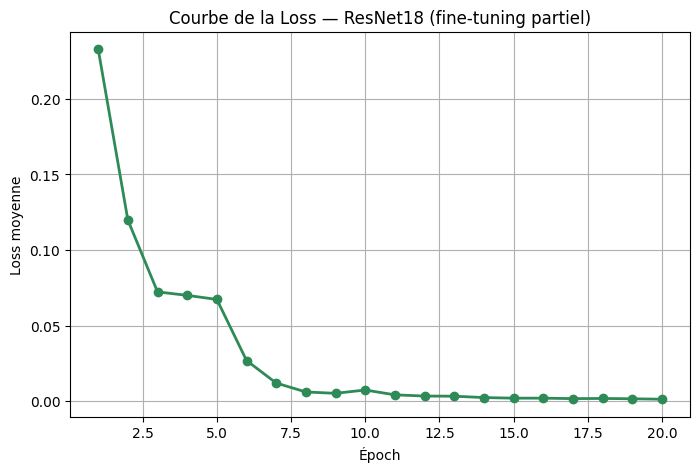

In [41]:
import matplotlib.pyplot as plt

losses_finetune_partial = [
    0.2328, 0.1198, 0.0723, 0.0700, 0.0673,
    0.0269, 0.0120, 0.0061, 0.0052, 0.0074,
    0.0042, 0.0034, 0.0033, 0.0024, 0.0020,
    0.0020, 0.0017, 0.0018, 0.0016, 0.0013
]

plt.figure(figsize=(8,5))
plt.plot(range(1, len(losses_finetune_partial)+1), losses_finetune_partial,
         marker='o', color='seagreen', linewidth=2)
plt.title("Courbe de la Loss — ResNet18 (fine-tuning partiel)")
plt.xlabel("Époch")
plt.ylabel("Loss moyenne")
plt.grid(True)
plt.show()


In [40]:
model_ft.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00         8
           3       1.00      0.91      0.95        11
           4       1.00      1.00      1.00        13
           5       1.00      1.00      1.00         9
           6       1.00      1.00      1.00         8
           7       1.00      1.00      1.00        17
           8       0.90      1.00      0.95         9
           9       1.00      1.00      1.00         9
          10       0.94      1.00      0.97        17
          11       1.00      1.00      1.00        17
          12       1.00      1.00      1.00        10
          13       1.00      0.90      0.95        10
          14       0.91      1.00      0.95        10
          15       1.00      0.88      0.93         8
          16       1.00      1.00      1.00        17
          17       0.94    

In [44]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9786


#On va prendre la version EfficientNet-B0

In [45]:
model_eff = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 117MB/s] 


In [46]:
num_features = model_eff.classifier[1].in_features
model_eff.classifier[1] = nn.Linear(num_features, 102)

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_eff = model_eff.to(device)

Geler toutes les couches

In [48]:
for param in model_eff.parameters():
    param.requires_grad = False


Débloquer la dernière partie (features[-1]) + classifier

In [49]:
for name, param in model_eff.named_parameters():
    if "features.6" in name or "features.7" in name or "classifier" in name:
        param.requires_grad = True


In [50]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model_eff.parameters()),
    lr=0.0003
)


In [51]:
epochs=20
for epoch in range(epochs):
    model_eff.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_eff(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
    scheduler.step()

Epoch [1/20], Loss: 2.4257
Epoch [2/20], Loss: 0.4878
Epoch [3/20], Loss: 0.2081
Epoch [4/20], Loss: 0.1235
Epoch [5/20], Loss: 0.0799
Epoch [6/20], Loss: 0.0616
Epoch [7/20], Loss: 0.0491
Epoch [8/20], Loss: 0.0412
Epoch [9/20], Loss: 0.0445
Epoch [10/20], Loss: 0.0363
Epoch [11/20], Loss: 0.0325
Epoch [12/20], Loss: 0.0286
Epoch [13/20], Loss: 0.0269
Epoch [14/20], Loss: 0.0231
Epoch [15/20], Loss: 0.0285
Epoch [16/20], Loss: 0.0229
Epoch [17/20], Loss: 0.0240
Epoch [18/20], Loss: 0.0259
Epoch [19/20], Loss: 0.0212
Epoch [20/20], Loss: 0.0203


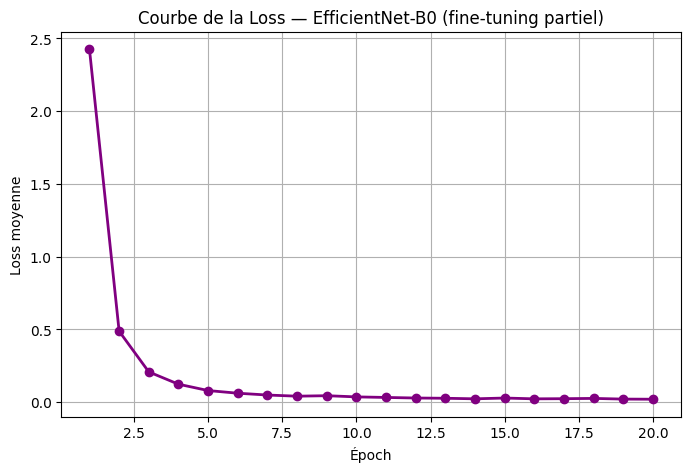

In [54]:
import matplotlib.pyplot as plt

losses_efficientnet = [
    2.4257, 0.4878, 0.2081, 0.1235, 0.0799,
    0.0616, 0.0491, 0.0412, 0.0445, 0.0363,
    0.0325, 0.0286, 0.0269, 0.0231, 0.0285,
    0.0229, 0.0240, 0.0259, 0.0212, 0.0203
]

plt.figure(figsize=(8,5))
plt.plot(range(1, len(losses_efficientnet)+1), losses_efficientnet,
         marker='o', color='purple', linewidth=2)
plt.title("Courbe de la Loss — EfficientNet-B0 (fine-tuning partiel)")
plt.xlabel("Époch")
plt.ylabel("Loss moyenne")
plt.grid(True)
plt.show()


In [52]:
model_ft.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00         8
           3       1.00      0.91      0.95        11
           4       1.00      1.00      1.00        13
           5       1.00      1.00      1.00         9
           6       0.89      1.00      0.94         8
           7       1.00      1.00      1.00        17
           8       0.89      0.89      0.89         9
           9       1.00      1.00      1.00         9
          10       0.94      1.00      0.97        17
          11       1.00      1.00      1.00        17
          12       1.00      1.00      1.00        10
          13       1.00      0.90      0.95        10
          14       1.00      1.00      1.00        10
          15       1.00      0.88      0.93         8
          16       1.00      1.00      1.00        17
          17       0.94    

In [53]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9750


In [55]:
!pip install grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 88.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=5fae9f14e41e09a65f8245123486943dfc20b96061fdf0d224e7f6b102b7daba
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [56]:
import torch
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import preprocess_image
import numpy as np
import cv2
import matplotlib.pyplot as plt


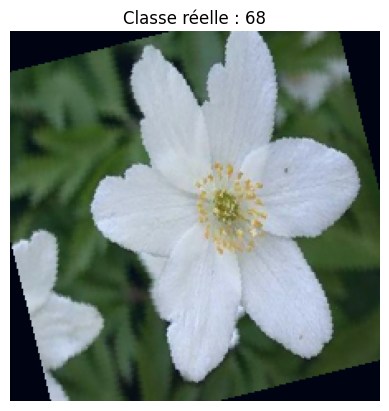

In [59]:

images, labels = next(iter(test_loader))

img_tensor = images[0].unsqueeze(0).to(device)
label = labels[0].item()

img_show = images[0].permute(1, 2, 0).cpu().numpy()
img_show = (img_show - img_show.min()) / (img_show.max() - img_show.min())

plt.imshow(img_show)
plt.title(f"Classe réelle : {label}")
plt.axis('off')
plt.show()


In [61]:
target_layers = [model_eff.features[-1]]
cam = GradCAM(model=model_eff, target_layers=target_layers)

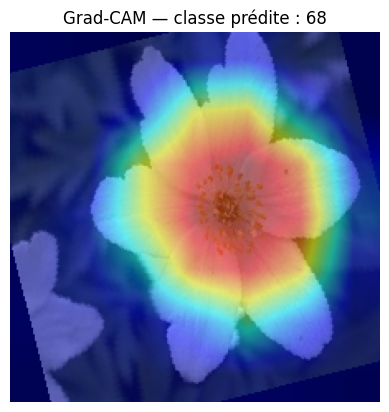

In [62]:

with torch.no_grad():
    output = model_eff(img_tensor)
pred_class = torch.argmax(output).item()

targets = [ClassifierOutputTarget(pred_class)]

grayscale_cam = cam(input_tensor=img_tensor, targets=targets)[0, :]

visualization = show_cam_on_image(img_show, grayscale_cam, use_rgb=True)
plt.imshow(visualization)
plt.title(f"Grad-CAM — classe prédite : {pred_class}")
plt.axis('off')
plt.show()


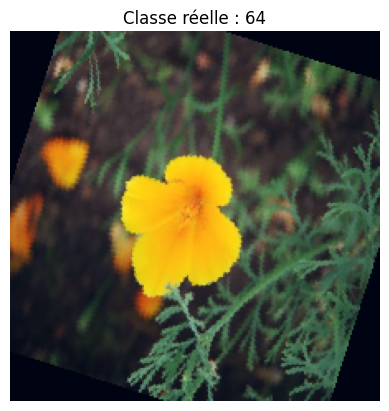

In [66]:
images, labels = next(iter(test_loader))

img_tensor = images[10].unsqueeze(0).to(device)
label = labels[10].item()

img_show = images[10].permute(1, 2, 0).cpu().numpy()
img_show = (img_show - img_show.min()) / (img_show.max() - img_show.min())

plt.imshow(img_show)
plt.title(f"Classe réelle : {label}")
plt.axis('off')
plt.show()

In [64]:
target_layers = [model_eff.features[-1]]
cam = GradCAM(model=model_eff, target_layers=target_layers)

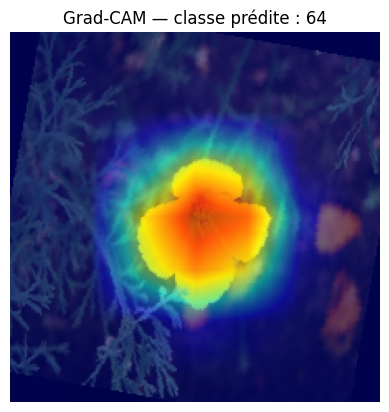

In [65]:
with torch.no_grad():
    output = model_eff(img_tensor)
pred_class = torch.argmax(output).item()

targets = [ClassifierOutputTarget(pred_class)]

grayscale_cam = cam(input_tensor=img_tensor, targets=targets)[0, :]

visualization = show_cam_on_image(img_show, grayscale_cam, use_rgb=True)
plt.imshow(visualization)
plt.title(f"Grad-CAM — classe prédite : {pred_class}")
plt.axis('off')
plt.show()

In [67]:
flower_names = [
    'pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold',
    'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', 'colt’s foot',
    'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily',
    'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger',
    'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william',
    'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya',
    'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily',
    'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion',
    'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium', 'bishop of llandaff', 'gaura', 'geranium',
    'orange dahlia', 'pink-yellow dahlia', 'cautleya spicata', 'japanese anemone', 'black-eyed susan',
    'silverbush', 'californian poppy', 'osteospermum', 'spring crocus', 'bearded iris', 'windflower',
    'tree poppy', 'gazania', 'azalea', 'water lily', 'rose', 'thorn apple', 'morning glory', 'passion flower',
    'lotus', 'toad lily', 'anthurium', 'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose',
    'tree mallow', 'magnolia', 'cyclamen', 'watercress', 'canna lily', 'hippeastrum', 'bee balm', 'ball moss',
    'foxglove', 'bougainvillea', 'camellia', 'mallow', 'mexican petunia', 'bromelia', 'blanket flower',
    'trumpet creeper', 'blackberry lily'
]


In [68]:
flower_names[64]

'californian poppy'

In [69]:
flower_names[68]

'windflower'

In [75]:
flower_names[87]

'cyclamen'

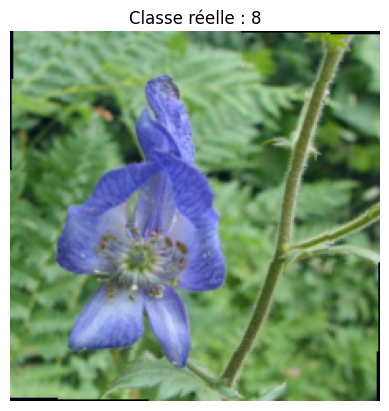

In [71]:
images, labels = next(iter(test_loader))

img_tensor = images[15].unsqueeze(0).to(device)
label = labels[15].item()

img_show = images[15].permute(1, 2, 0).cpu().numpy()
img_show = (img_show - img_show.min()) / (img_show.max() - img_show.min())

plt.imshow(img_show)
plt.title(f"Classe réelle : {label}")
plt.axis('off')
plt.show()

In [72]:
target_layers = [model_eff.features[-1]]
cam = GradCAM(model=model_eff, target_layers=target_layers)

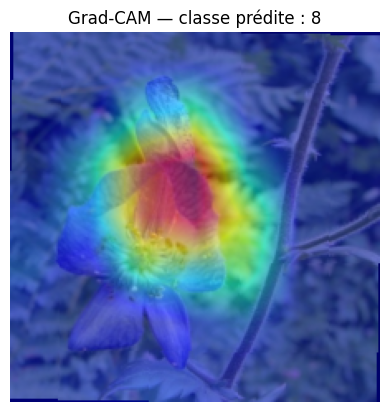

In [73]:
with torch.no_grad():
    output = model_eff(img_tensor)
pred_class = torch.argmax(output).item()

targets = [ClassifierOutputTarget(pred_class)]

grayscale_cam = cam(input_tensor=img_tensor, targets=targets)[0, :]

visualization = show_cam_on_image(img_show, grayscale_cam, use_rgb=True)
plt.imshow(visualization)
plt.title(f"Grad-CAM — classe prédite : {pred_class}")
plt.axis('off')
plt.show()

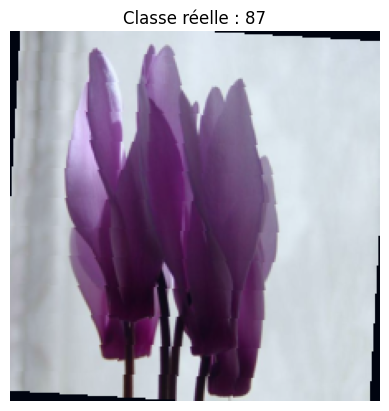

In [74]:
images, labels = next(iter(test_loader))

img_tensor = images[23].unsqueeze(0).to(device)
label = labels[23].item()

img_show = images[23].permute(1, 2, 0).cpu().numpy()
img_show = (img_show - img_show.min()) / (img_show.max() - img_show.min())

plt.imshow(img_show)
plt.title(f"Classe réelle : {label}")
plt.axis('off')
plt.show()

In [76]:
target_layers = [model_eff.features[-1]]
cam = GradCAM(model=model_eff, target_layers=target_layers)

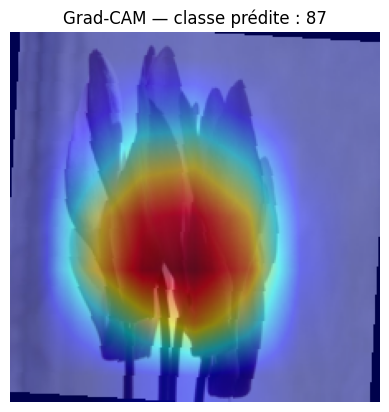

In [77]:
with torch.no_grad():
    output = model_eff(img_tensor)
pred_class = torch.argmax(output).item()

targets = [ClassifierOutputTarget(pred_class)]

grayscale_cam = cam(input_tensor=img_tensor, targets=targets)[0, :]

visualization = show_cam_on_image(img_show, grayscale_cam, use_rgb=True)
plt.imshow(visualization)
plt.title(f"Grad-CAM — classe prédite : {pred_class}")
plt.axis('off')
plt.show()